# Getting Started

## Read CSV and Import


In [2]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')


## Helper Functions

In [3]:

def create_X_y(df):
  y = None
  # map y values if they exist
  if 'y' in df:
    value_map = {
      'yes': 1,
      'no': 0
    }
    df['y_encoded'] = df['y'].map(value_map)
    y = df['y_encoded'].astype(bool)


  # data bins
  # These have been added in attempts to get better results
  age_bins = [0, 20, 40, 60, 80]
  age_labels = ['young', 'middle-aged', 'old', 'very_old']
  campaign['age_bin'] = pd.cut(campaign['age'], age_bins, labels=age_labels )

  # Mostly have been dropping pdays because of the # of 999 aka not contacted values, but tried using bins to see if it would help with results.
  pdays_bins = [0, 3, 7, 998, 1000]
  pdays_labels = ['very_recent', 'recent', 'not_recent', 'not_contacted']
  campaign['pdays_bin'] = pd.cut(campaign['pdays'], pdays_bins, labels=pdays_labels )


  # scale data - more attempts to find better results.

  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  features_to_be_scaled = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
  scaler = MinMaxScaler()

  # Set features for X and create dummies for the ones that need it
  X = df[['job','age_bin', 'loan', 'housing', 'day_of_week', 'pdays_bin', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

  X = pd.get_dummies(X, columns=['job', 'loan', 'housing', 'day_of_week', 'age_bin', 'pdays_bin'], drop_first=True)
  X[features_to_be_scaled] = scaler.fit_transform(X[features_to_be_scaled])


  return X,y

# Model Training

## Data Prep for specific model

Create x,y

In [4]:
X,y = create_X_y(campaign)

# verifying our X has scaled data
print(X.head())

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  \
0        0.9375        0.698753        0.60251   0.957379     0.859735   
1        0.9375        0.698753        0.60251   0.957379     0.859735   
2        0.9375        0.698753        0.60251   0.957379     0.859735   
3        0.9375        0.698753        0.60251   0.957379     0.859735   
4        0.9375        0.698753        0.60251   0.957379     0.859735   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0            False             False           True           False   
1            False             False          False           False   
2            False             False          False           False   
3            False             False          False           False   
4            False             False          False           False   

   job_retired  ...  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0        False  ...             True            False 

### Split the data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)




# commented out print statments to remove clutter.  These just show info about the split
# print(X_train.head())
# print(X.info())
# print(y_train.head())

## Train the Model

In [6]:
# these are the different classifiers we've been testing with.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=100, random_state=0)
# clf = HistGradientBoostingClassifier()

clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.8760902796511105

## Make predictions

In [7]:
predictions = clf.predict(X_test)
print(predictions)



[False False False ... False False False]


## Results

### Results data

In [8]:
# code obtained from google to quickly get count of each value from np array
import numpy as np

unique_values, counts = np.unique(predictions, return_counts=True)

value_counts = dict(zip(unique_values, counts))

print("Predictions value counts")
print(value_counts)
print("------------")
print("Should be:")
print(y_test.value_counts())


Predictions value counts
{np.False_: np.int64(10249), np.True_: np.int64(872)}
------------
Should be:
y_encoded
False    9891
True     1230
Name: count, dtype: int64


### Metrics

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision: ",precision_score(y_test, predictions))
print("Recall", recall_score(y_test, predictions))
print("F1", f1_score(y_test, predictions))

Accuracy: 0.8760902796511105
Precision:  0.4151376146788991
Recall 0.2943089430894309
F1 0.34443387250237867


<Axes: >

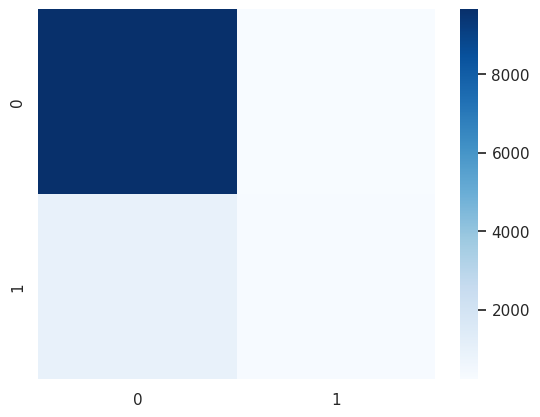

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, cmap="Blues")

# Tune the model


## Max Depth -- F1

In [ ]:
# find best max_depth for best f1 score
best_f1_score = 0
best_max_depth = 0

for i in range(1, 25, 1):
  clf = GradientBoostingClassifier(n_estimators=32, learning_rate=1.0, max_depth=i, random_state=0)
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  current_f1_score = f1_score(y_test, predictions)
  print(f"Current f1 score: {current_f1_score} with max depth: {i}")
  if current_f1_score > best_f1_score:
    best_f1_score = current_f1_score
    best_max_depth = i


print("Best f1 score is: ", best_f1_score)
print("The max depth used was: ", best_max_depth)




Current f1 score: 0.2906906906906907 with max depth: 1
Current f1 score: 0.3123543123543124 with max depth: 2
Current f1 score: 0.34501947690595436 with max depth: 3
Current f1 score: 0.33276740237691 with max depth: 4
Current f1 score: 0.33351924149470163 with max depth: 5
Current f1 score: 0.34950385887541346 with max depth: 6
Current f1 score: 0.3392070484581498 with max depth: 7
Current f1 score: 0.3324130314743236 with max depth: 8
Current f1 score: 0.33854447439353097 with max depth: 9
Current f1 score: 0.318955732122588 with max depth: 10
Current f1 score: 0.30335097001763667 with max depth: 11
Current f1 score: 0.3177054605626034 with max depth: 12
Current f1 score: 0.3223647518126046 with max depth: 13
Current f1 score: 0.32128960533629797 with max depth: 14
Current f1 score: 0.28080568720379145 with max depth: 15
Current f1 score: 0.28134196586227195 with max depth: 16
Current f1 score: 0.323094425483504 with max depth: 17
Current f1 score: 0.3000577034045009 with max depth: 

## n_estimators -- F1

In [ ]:
best_f1_score = 0
best_n_estimators = 0


for i in range(2, 150, 10):
  clf = GradientBoostingClassifier(n_estimators=i, learning_rate=1.0, max_depth=best_max_depth, random_state=0)
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  current_f1_score = f1_score(y_test, predictions)
  print(f"Current f1 score: {current_f1_score} with n_estimators: {i}")
  if current_f1_score > best_f1_score:
    best_f1_score = current_f1_score
    best_n_estimators = i

print("Best f1 score is: ", best_f1_score)
print("The n_estimators used was: ", best_n_estimators)

Current f1 score: 0.0715372907153729 with n_estimators: 2
Current f1 score: 0.345679012345679 with n_estimators: 12
Current f1 score: 0.35555555555555557 with n_estimators: 22
Current f1 score: 0.34950385887541346 with n_estimators: 32
Current f1 score: 0.343646408839779 with n_estimators: 42
Current f1 score: 0.343646408839779 with n_estimators: 52
Current f1 score: 0.3376044568245125 with n_estimators: 62
Current f1 score: 0.3379655364091162 with n_estimators: 72
Current f1 score: 0.3412742382271468 with n_estimators: 82
Current f1 score: 0.3425720620842572 with n_estimators: 92
Current f1 score: 0.3377926421404682 with n_estimators: 102
Current f1 score: 0.33962264150943394 with n_estimators: 112
Current f1 score: 0.3449805879090405 with n_estimators: 122
Current f1 score: 0.3487858719646799 with n_estimators: 132
Current f1 score: 0.343871325568497 with n_estimators: 142
Best f1 score is:  0.35555555555555557
The n_estimators used was:  22


## Learning Rate -- F1




In [ ]:
best_f1_score = 0
best_learning_rate = 0

for i in range(5, 40):
  lr = i/10
  clf = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=lr, max_depth=best_max_depth, random_state=0)
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  current_f1_score = f1_score(y_test, predictions)
  print(f"Current f1 score: {current_f1_score} with learning_rate: {i}")
  if current_f1_score > best_f1_score:
    best_f1_score = current_f1_score
    best_learning_rate = lr

print("Best f1 score is: ", best_f1_score)
print("The learning_rate used was: ", best_learning_rate)

Current f1 score: 0.33896396396396394 with learning_rate: 5
Current f1 score: 0.3479224376731302 with learning_rate: 6
Current f1 score: 0.34092171016102163 with learning_rate: 7
Current f1 score: 0.3331463825014021 with learning_rate: 8
Current f1 score: 0.33851276359600446 with learning_rate: 9
Current f1 score: 0.35555555555555557 with learning_rate: 10
Current f1 score: 0.2540638169777243 with learning_rate: 11
Current f1 score: 0.39902439024390246 with learning_rate: 12
Current f1 score: 0.33402489626556015 with learning_rate: 13
Current f1 score: 0.4257845631891433 with learning_rate: 14
Current f1 score: 0.3887277248238707 with learning_rate: 15
Current f1 score: 0.39865715484683173 with learning_rate: 16
Current f1 score: 0.32575757575757575 with learning_rate: 17
Current f1 score: 0.3480296527506828 with learning_rate: 18
Current f1 score: 0.42771084337349397 with learning_rate: 19
Current f1 score: 0.3702609551944855 with learning_rate: 20
Current f1 score: 0.357553803537183 

# Tuned Results

In [ ]:

clf = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=0)
print(clf)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
print("X test shape", X_test.shape)
predictions = clf.predict(X_test)



# our own version of accuracy -- some google code to print the results and what really should be the results.
# look at the value counts for true and false
unique_values, counts = np.unique(predictions, return_counts=True)
value_counts = dict(zip(unique_values, counts))
print("Predictions value counts")
print(value_counts)
print("------------")
print("Should be:")
print(y_test.value_counts())


print("\n\n")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision: ",precision_score(y_test, predictions))
print("Recall", recall_score(y_test, predictions))
print("F1", f1_score(y_test, predictions))

GradientBoostingClassifier(learning_rate=1.9, max_depth=6, n_estimators=22,
                           random_state=0)
X test shape (11121, 13)
Predictions value counts
{np.False_: np.int64(9363), np.True_: np.int64(1758)}
------------
Should be:
y_encoded
False    9891
True     1230
Name: count, dtype: int64



Accuracy: 0.8462368492042083
Precision:  0.363481228668942
Recall 0.5195121951219512
F1 0.42771084337349397


<Axes: >

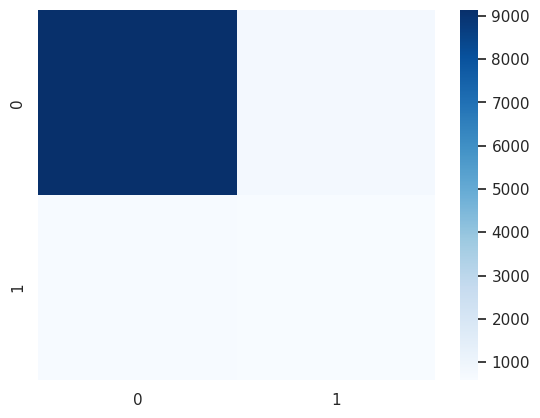

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, cmap="Blues")

In [ ]:
print(X.describe())
print(X.info())

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed
count  37069.000000    37069.000000   37069.000000  37069.000000  37069.000000
mean       0.725318        0.536068       0.431179      0.677385      0.769038
std        0.327560        0.225775       0.193678      0.393221      0.273325
min        0.000000        0.000000       0.000000      0.000000      0.000000
25%        0.333333        0.340608       0.338912      0.160961      0.512287
50%        0.937500        0.603274       0.376569      0.957379      0.859735
75%        1.000000        0.698753       0.602510      0.980957      1.000000
max        1.000000        1.000000       1.000000      1.000000      1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   emp.var.rate     37069 non-null  float64
 1   cons.price.idx   37069 non-null  floa

# Holdout data

In [1]:
# ## holdout data
# holdout_data = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank_holdout_test.csv")
# holdout_X, holdout_y = create_X_y(holdout_data)

# holdout_X.info()

# holdout_prediction = clf.predict(holdout_X)

# print(holdout_prediction.shape)